#### Cvičení 2 - Neuronová síť

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy as sc
pandas.set_option("display.precision", 3)
from sklearn.neural_network import MLPClassifier

#### Načtení dat

In [2]:
fileName = 'GSR_hrac1.xlsx'
dataHra2 = pandas.read_excel(fileName, sheet_name="Hra_2")
dataCopy = dataHra2

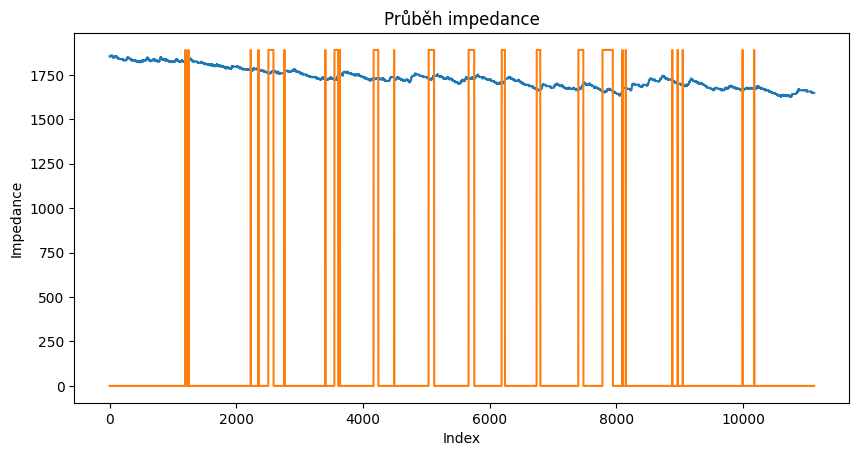

In [3]:
plt.plot(range(len(dataCopy)), dataCopy["Data"])
plt.plot(range(len(dataCopy)), dataCopy["Peak"])
figure = plt.gcf()
figure.set_figwidth(10)
plt.xlabel("Index")
plt.ylabel("Impedance")
plt.title("Průběh impedance")
plt.show()

#### Úprava dat

In [4]:
# přepis stresové hodnoty 2 na 1
dataCopy.loc[(dataCopy.Stres == 2), "Stres"] = 1
impedance = list(dataCopy["Data"].copy().to_numpy())
stres = list(dataCopy["Stres"].copy().to_numpy())

#### Funkce pro výpočet příznaků pro neuronové sítě

In [5]:
def rozdelitStres(impData, stresData):
    """
    Funkce rozdělí sloupec impedancí do skupin podle stresového stavu.
    Výstupem jsou listy listů impedančních hodnot.
    """

    impedanceSkupiny = []
    aktualniSkupina = []

    for index in range(len(impData)):
        # ukončení cyklu, pokud je index na posledním řádku
        if index == len(impData) - 1:
            aktualniSkupina.append(impData[index])
            impedanceSkupiny.append(aktualniSkupina)
            break
        
        # zápis hodnot impedance v úseku se stejným stresovým stavem
        if stresData[index] == stresData[index + 1]:
            aktualniSkupina.append(impData[index])

        # zápis skupiny hodnot při změně stresového stavu
        elif stresData[index] != stresData[index + 1]:
            aktualniSkupina.append(impData[index])
            impedanceSkupiny.append(aktualniSkupina)
            aktualniSkupina = []

    return impedanceSkupiny[0::2], impedanceSkupiny[1::2]

def statistikaSkupin(listSkupin):
    """
    Funkce vypočítá základní statistické údaje každé skupiny vstupního listu: 
        - průměr, směrodatná odchylka, plocha/integrál, moment.
    Výstupem je dictionary hodnot každé skupiny.
    """

    prumerSkupin = [np.mean(skupina) for skupina in listSkupin]
    stdSkupin = [np.std(skupina) for skupina in listSkupin]
    plochaSkupin = [np.trapz(skupina, np.arange(len(skupina))) for skupina in listSkupin]
    momentSkupin = [sc.stats.moment(skupina, 2) for skupina in listSkupin]
    return {"prumer": prumerSkupin, "std": stdSkupin, 
            "plocha": plochaSkupin, "moment": momentSkupin}

def entropieSkupin(listSkupin):
    """
    Funkce vypočítá entropii každé skupiny vstupního listu.
    Výstupem je list entropií každé skupiny.
    """

    listEntropii = []
    for skupina in listSkupin:
        histSkupina, _ = np.histogram(skupina) # počet hodnot histogram binech
        histSkupina = histSkupina[histSkupina != 0] # odebrání nulových hodnot
        histSkupina = histSkupina / len(histSkupina) # normalizace
        listEntropii.append(-np.sum(histSkupina * np.log(histSkupina))) # entropie
    return listEntropii

def detekcePeakuSkupiny(listSkupin):
    """
    Funkce detekuje indexy a amplitudy peaků každé skupiny vstupního listu.
    Dále spočítá jejich průměr a sumu.
    Výstupem je dictionary hodnot každé skupiny.
    """
    listPocetPeaku = []
    listPrumerAmp = []
    listSumaAmp = []

    for skupina in listSkupin:
        skupina = np.array(skupina)
        filtSkupina = sc.signal.medfilt(skupina, 5)
        
        # detekce peaku
        if len(skupina) > 2:
            indexySkupina, _ = sc.signal.find_peaks(skupina)
            amplitudySkupina = skupina[indexySkupina]
        else:
            indexySkupina = 0
            amplitudySkupina = 0
        
        if indexySkupina.size > 0:
            pocetPeaku = len(indexySkupina)
            prumerAmplitud = np.mean(amplitudySkupina)
            sumaAmplitud = np.sum(amplitudySkupina)
        else:
            pocetPeaku = prumerAmplitud = sumaAmplitud = 0

        listPocetPeaku.append(pocetPeaku)
        listPrumerAmp.append(prumerAmplitud)
        listSumaAmp.append(sumaAmplitud)

    return {"pocetIndexu": listPocetPeaku, "prumer": listPrumerAmp, "suma": listSumaAmp}

#### Rozdělení vektoru impedancí na skupiny podle stresového stavu

In [6]:
klidSkupiny, stresSkupiny = rozdelitStres(impedance, stres)
print(f"Počet skupin, klid: {len(klidSkupiny)}, stres: {len(stresSkupiny)}")

Počet skupin, klid: 25, stres: 24


#### Výpočet příznaků pro neuronovou síť
##### Impedanční hodnoty klidového stavu

In [11]:
klidStatistikaSkupin = statistikaSkupin(klidSkupiny)
klidEntropie = entropieSkupin(klidSkupiny)
klidPeakySkupin = detekcePeakuSkupiny(klidSkupiny)
klidLabel = 1 * np.ones(shape=len(klidEntropie))

stresStatistikaSkupin = statistikaSkupin(stresSkupiny)
stresEntropie = entropieSkupin(stresSkupiny)
stresPeakySkupin = detekcePeakuSkupiny(stresSkupiny)
stresLabel = 2 * np.ones(shape=len(stresEntropie))

C:\Users\vojte\AppData\Local\Temp\ipykernel_11896\4238813609.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  momentSkupin = [sc.stats.moment(skupina, 2) for skupina in listSkupin]


##### Numpy pole hodnot klidového a stresového stavu

In [23]:
klidPole = np.array([klidStatistikaSkupin['prumer'], klidStatistikaSkupin['std'], 
              klidStatistikaSkupin['plocha'], klidEntropie, 
              klidStatistikaSkupin['moment'], klidPeakySkupin['pocetIndexu'], 
              klidPeakySkupin['prumer'], klidPeakySkupin['suma'], klidLabel], dtype=np.float64)

stresPole = np.array([stresStatistikaSkupin['prumer'], stresStatistikaSkupin['std'], 
            stresStatistikaSkupin['plocha'], stresEntropie, 
            stresStatistikaSkupin['moment'], stresPeakySkupin['pocetIndexu'], 
            stresPeakySkupin['prumer'], stresPeakySkupin['suma'], stresLabel], dtype=np.float64)
print(f"Pole hodnot: klid: {klidPole.shape}, stres: {stresPole.shape}")

klidStresPole = np.hstack((klidPole, stresPole))
klidStresPole = np.transpose(klidStresPole)
radky = klidStresPole.shape[0]

sloupce = ["Průměr", "Směr. odchylka", "Plocha", "Entropie", "Moment", 
           "Počet indexů", "Průměr amplitud", "Suma amplitud", "Label"]

klidTabulka = pandas.DataFrame(klidStresPole, columns=sloupce)
klidTabulka.set_index(pandas.Index(range(1, radky + 1), name="Skupina"))

Pole hodnot: klid: (9, 25), stres: (9, 24)


,Průměr,Směr. odchylka,Plocha,Entropie,Moment,Počet indexů,Průměr amplitud,Suma amplitud,Label
Skupina,,,,,,,,,
1,1834.246,8.895,2.196e+06,-350.810,79.115,110.0,1835.055,201856.0,1.0
2,1831.821,1.483,6.961e+04,-14.038,2.199,6.0,1833.333,11000.0,1.0
3,1802.149,15.693,1.755e+06,-235.488,246.268,121.0,1803.273,218196.0,1.0
4,1780.456,4.132,2.012e+05,-20.918,17.073,8.0,1783.500,14268.0,1.0
5,1769.897,5.539,2.566e+05,-16.772,30.681,14.0,1774.071,24837.0,1.0
6,1762.058,4.933,3.013e+05,-32.781,24.334,21.0,1765.000,37065.0,1.0
7,1751.138,17.194,1.115e+06,-132.701,295.620,51.0,1754.510,89480.0,1.0
8,1727.919,3.397,2.315e+05,-24.823,11.542,17.0,1730.647,29421.0,1.0
9,1743.714,0.700,4.708e+04,-31.205,0.490,0.0,0.000,0.0,1.0


In [24]:
np.random.seed(0)
noveIndexyRadku = np.random.randint(0, klidStresPole.shape[0], size=klidStresPole.shape[0])
klidStresPolePrehazene = klidStresPole[noveIndexyRadku, :]
klidTabulka = pandas.DataFrame(klidStresPolePrehazene, columns=sloupce)
klidTabulka.set_index(pandas.Index(range(1, radky + 1), name="Skupina"))

,Průměr,Směr. odchylka,Plocha,Entropie,Moment,Počet indexů,Průměr amplitud,Suma amplitud,Label
Skupina,,,,,,,,,
1,1718.500,2.784,1.203e+04,1.743,7.750,1.0,1717.000,1717.0,2.0
2,1662.778,0.629,1.330e+04,-5.199,0.395,0.0,0.000,0.0,2.0
3,1834.246,8.895,2.196e+06,-350.810,79.115,110.0,1835.055,201856.0,1.0
4,1780.456,4.132,2.012e+05,-20.918,17.073,8.0,1783.500,14268.0,1.0
5,1780.456,4.132,2.012e+05,-20.918,17.073,8.0,1783.500,14268.0,1.0
6,1664.897,2.934,9.490e+04,-15.528,8.610,4.0,1669.000,6676.0,2.0
7,1745.512,14.352,9.112e+05,-94.570,205.990,63.0,1745.381,109959.0,1.0
8,1706.732,21.287,1.232e+06,-162.950,453.140,41.0,1708.073,70031.0,1.0
9,1697.472,2.867,1.205e+05,-35.262,8.221,2.0,1698.000,3396.0,1.0


In [31]:
labelVektor = klidStresPolePrehazene[:, -1]
labels = np.unique(labelVektor)


In [38]:
idx = np.zeros((labelVektor.size, int(labelVektor.max())+1), dtype=int)
# idx[np.arange(labelVektor.size), int(labelVektor)] = 1

In [ ]:
net = MLPClassifier()

In [47]:
target = sc.sparse.csr_array(labelVektor, dtype=int)
print(target)

  (0, 0)	2
  (0, 1)	2
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	2
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	2
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	2
  (0, 17)	2
  (0, 18)	1
  (0, 19)	2
  (0, 20)	1
  (0, 21)	1
  (0, 22)	2
  (0, 23)	2
  (0, 24)	1
  (0, 25)	1
  (0, 26)	1
  (0, 27)	1
  (0, 28)	1
  (0, 29)	1
  (0, 30)	1
  (0, 31)	2
  (0, 32)	1
  (0, 33)	1
  (0, 34)	2
  (0, 35)	1
  (0, 36)	2
  (0, 37)	1
  (0, 38)	1
  (0, 39)	1
  (0, 40)	2
  (0, 41)	2
  (0, 42)	1
  (0, 43)	1
  (0, 44)	2
  (0, 45)	2
  (0, 46)	1
  (0, 47)	1
  (0, 48)	2
